# An analysis of an IMDb data snapshot. What films are highly viewed / rated, and what new films should I watch?

***

## Information about the data:

The data is taken from https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset, downloaded as csv files and uploaded to my own Postgres database. Whilst csv files could be directly accessed and manipulated via Python (Pandas), I wanted to gain experience managing and querying data in a database. The data set was up to date as of 2020, and so this analysis is a reflection of the data at that time.

Whilst the full data set contains all movies listed on IMDb, my queries will more than likely only consist of movies where English is a listed language and where there are more than 5000 recorded votes. I understand there is some bias to these restrictions, but my reasoning is as follows. To the former point, I am an English speaker and am primarily interested in English spoken movies. This is not always the case, but upon querying the database there were far too many non-English spoken films, and this did not benefit me in my aims for this analysis. To the latter point, movie ratings were heavily skewed by a lack of votes. The average vote count across all movies was just over 9000. I understand that newer movies are heavily discriminated by using this metric, but it was more beneficial overall. I settled on including all movies that had at least 5000 votes.

## What this notebook is:

This notebook contains an exploratory analysis into what films are popular. It will also serve as a means for me to find new films to watch, by querying the data set for the common features amongst the films I currently enjoy. By this analysis, I hope to gain a better understanding into why films are popular / highly rated, as well as finding 'hidden gems' that appeal to my tastes.

***

## Code imports and helper function for querying the database:

In [17]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import configparser

# read database parameters from a config file
try:
    config = configparser.ConfigParser()
    config.read('config.ini')
    params = dict(config['DEFAULT'])
except:
    print('No config.ini file found.')

In [2]:
def query_db(query, params):
    '''Execute SQL queries passed to this function and return query results as data frame'''
    
    conn = None
    try:
        conn = psycopg2.connect(**params)
        df = pd.read_sql_query(query, conn)
        conn.close()
        return(df)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

***

## Analysis:

__*Highly Rated Films*__
<br>Let's first take a look at the 10 highest rated films as a starting point.

In [11]:
# The top 10 highest rated films with restrictions
top_10_query = '''
    select original_title, year, genre, duration, avg_vote, votes
    from movies
    where language like '%English%' and votes > 5000
    order by avg_vote desc, votes desc
    limit 10;
'''

df_top_10 = query_db(top_10_query, params)
df_top_10

,original_title,year,genre,duration,avg_vote,votes
0,The Shawshank Redemption,1994,Drama,142,9.3,2278845
1,The Godfather,1972,"Crime, Drama",175,9.2,1572674
2,The Dark Knight,2008,"Action, Crime, Drama",152,9.0,2241615
3,The Godfather: Part II,1974,"Crime, Drama",202,9.0,1098714
4,Pulp Fiction,1994,"Crime, Drama",154,8.9,1780147
5,The Lord of the Rings: The Return of the King,2003,"Action, Adventure, Drama",201,8.9,1604280
6,Schindler's List,1993,"Biography, Drama, History",195,8.9,1183248
7,12 Angry Men,1957,"Crime, Drama",96,8.9,668473
8,Inception,2010,"Action, Adventure, Sci-Fi",148,8.8,2002816
9,Fight Club,1999,Drama,139,8.8,1807440


In [4]:
# Average rating across all films with restrictions
avg_rat_query = '''
    select avg(avg_vote) as avg_vote
    from movies
    where language like '%English%' and votes > 5000
'''

# adding original_title field to result for later joining with other df
df_avg_rat = query_db(avg_rat_query, params)
df_avg_rat['original_title'] = 'Average Film Rating (All Films)'
df_avg_rat

,avg_vote,original_title
0,6.461674,Average Film Rating (All Films)


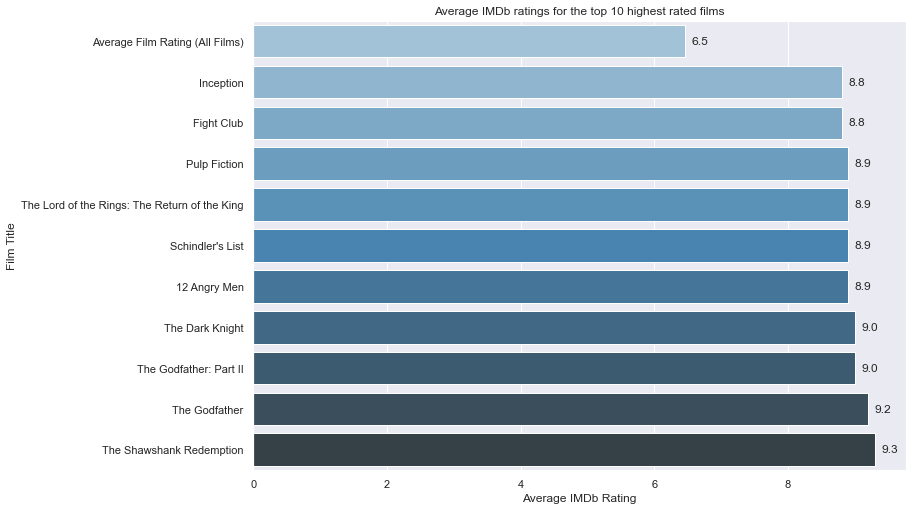

In [12]:
# join avg film rating to top 10 ratings and display as bar chart
df_rat_graph = df_top_10[['original_title', 'avg_vote']]
df_rat_graph = df_rat_graph.append(df_avg_rat, ignore_index=True)
df_rat_graph = df_rat_graph.sort_values(by=['avg_vote'])

sns.set_theme(style='whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(data=df_rat_graph, y='original_title', x='avg_vote', palette='Blues_d')
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+0.1, # x-coordinate position of data label, padded 3 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = '{:.1f}'.format(width), # data label, formatted to ignore decimals
    va = 'center') # sets vertical alignment (va) to center
ax.set(ylabel='Film Title', xlabel='Average IMDb Rating', title='Average IMDb ratings for the top 10 highest rated films');

I have seen most of these films, probably because I was aware of their popularity and high ratings ahead of time. Regardless, for those on this list that I have seen, I would agree that they were very good films. All of the films in the top 10 highest rated list are significantly higher than the average film rating for all films. 10th place, Inception, is a significant 2.3 points out of 10 higher than the average rating.

Let's take a look at the distribution of ratings of films.

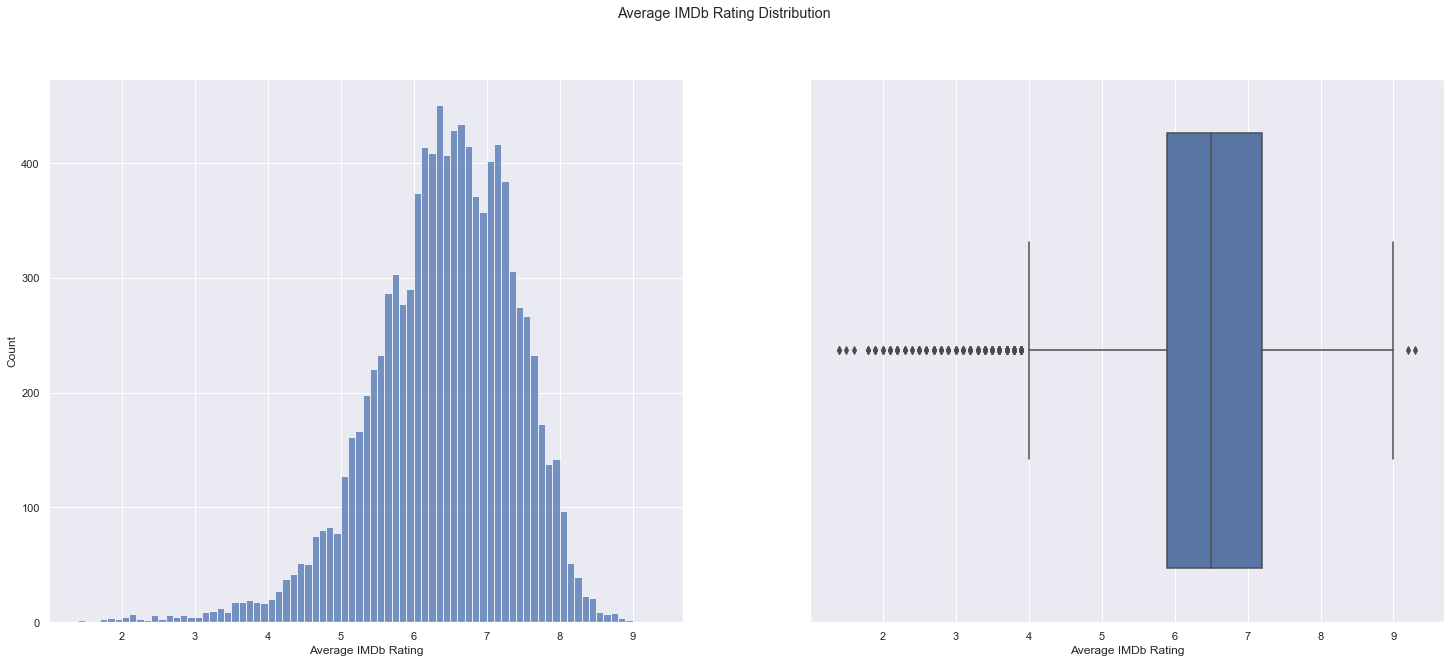

In [28]:
all_rat_query = '''
    select avg_vote
    from movies
    where language like '%English%' and votes > 5000
'''
df = query_db(all_rat_query, params)

fig, ax = plt.subplots(1,2,figsize=(25,10))
sns.histplot(data=df, x='avg_vote', binwidth=0.1, ax=ax[0])
sns.boxplot(data=df, x='avg_vote', ax=ax[1])
fig.suptitle('Average IMDb Rating Distribution')
ax[0].set(xlabel='Average IMDb Rating')
ax[1].set(xlabel='Average IMDb Rating');

The distribtuion of films is interesting. There are obviously a number of outliers corresponding to particularly low IMDb ratings. The distribution is also heavily skewed such that the IQR contains values corresponding to ratings between roughly 5.8 and 7.3. It is interesting that such a large number of ratings are clustered between these values. It might be more accurate to consider inadequecies in the 'rating out of 10' system and the psychology of how people rate things, rather than take these values as a true reflection of a film's objetive worth. Regardless, this distribution again highlights that the top rated films are rated significantly high.

***

In [ ]:
# this is a bad query as it takes only the first genre in the string, genres are listed alphabetically so that genres such as drama are over represented. Need to find a way to include every film in every
# group by for each genre it is.
bad_query = '''
    select substring(genre from '^[a-zA-Z]+'), count(*) as num_films_in_genre, avg(avg_vote) as avg_vote_of_genre
    from movies
    where language like '%English%' and votes > 5000
    group by substring(genre from '^[a-zA-Z]+')
    having count(*) > 10
    order by avg(avg_vote) desc
    limit 10;
'''

***

__*Highly Rated Directors*__
<br>Let's explore some information about the directors included in the data set, starting with those that directed the top 10 highest rated films.